In [8]:
from altaipony.lcio import from_mast, from_path
from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery
from altaipony.altai import find_iterative_median

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from funcs import write_flares_to_file, read_custom_aperture_lc

from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt
import copy

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.

In [9]:
clcs = ! ls /work1/eilin/TESS_UCDs/TESS_UCD_flares/custom_aperture/*fits
clcs = [x.split("/")[-1] for x in clcs]

def get_customlc(TIC, c, clcs):
    for p in clcs:
        if (str(TIC) in p.split("-")[2]) & (c == int(p.split("-")[1][1:])):
            print(p)
            pac = p
    return pac

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1], window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [10]:
paths = ! ls /work1/eilin/TESS_UCDs/injrec/
ids = [p.split("_")[2]for p in paths]
cs = [p.split("_")[3][:-4]for p in paths]
targs = list(zip(ids,cs))
targs = list(set(targs))
len(targs)

191

In [14]:
TIC, c = targs[0]
df = pd.DataFrame()
for p in paths:
    if ((TIC in p) & (c in p)):
        df = df.append(pd.read_csv("/work1/eilin/TESS_UCDs/injrec/"+p), ignore_index=True)

In [19]:
df.shape

(6000, 16)

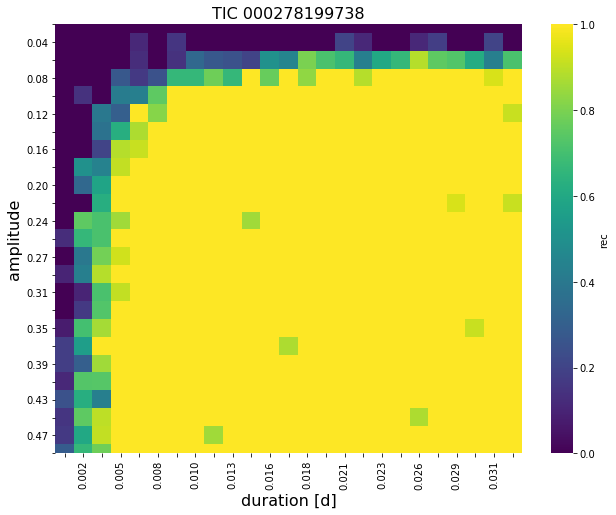

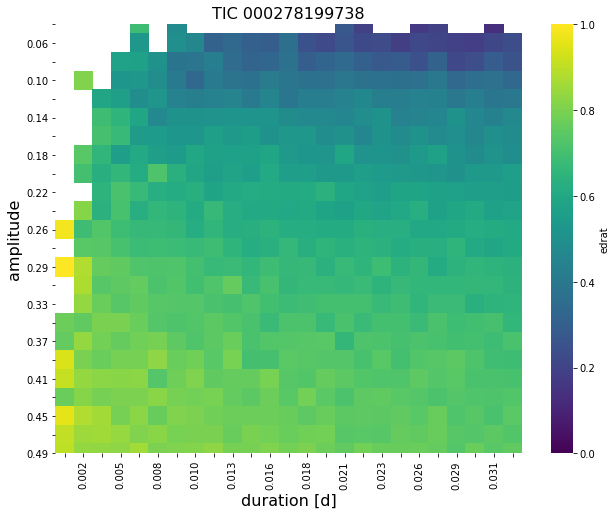

In [18]:

bins = 25
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);
dff, val = tile_up_injection_recovery(df, "ed_ratio",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);

In [1977]:
pac = get_customlc(TIC, c, clcs)
print(pac)
pac = "/work1/eilin/TESS_UCDs/TESS_UCD_flares/custom_aperture/" + pac

166ca_tess2019100211231-s0012-0000000142052876-0000-s_lc.fits
166ca_tess2019100211231-s0012-0000000142052876-0000-s_lc.fits


In [1978]:
flc = read_custom_aperture_lc(pac)

# Fix window length -----------------------------------------------------
#rapid rotators
TIC = flc.targetid
if TIC in [
           471012740, ]: 
    w = 5
#intermediate rotators/ variability time scale / some weird systematics
elif TIC in [98874143, 388903843, 
             332623751,  44892011, 
             44892011, 117733581, 29780677, 
             340703996, 395130640, 441000085,
             53603145,144776281,]:
    w = 25
# little variability
elif TIC in [471012740, 125835702, 30101427, 415839928, 
             398985964, 322568489, 2470992, 1539914,
              117733581,73118477]:
    w = 555
# medium rotators
elif TIC in [471012770, 5630425, 140478472,
             142052876,272349442, 277539431,293561794,
             369555560,464378628]:
    w = 55
# special snowflake
elif TIC in [44984200,]:
    w = 15
elif TIC in [29928567,298907057, 366567664, 369863567, 420001446]:
    w=75
elif TIC == 328254412:
    w = 115

# default: little variablity
else:
    w = None
if w is None:
    flc = flc[np.where(np.isfinite(flc.flux))]
    flcp = copy.deepcopy(flc)
else:
    #flc = flc[np.where(np.isfinite(flc.flux))]
    flcp = flc.detrend("savgol", window_length=w)
#plt.plot(flcp.cadenceno, flcp.detrended_flux)
    flcp.flux[:] =  copy.deepcopy(flcp.detrended_flux)
p3s = []
#flc = flc[np.where(np.invert(np.isnan(flc.flux)))[0]]
#flcp = copy.deepcopy(flc)
flcp = flcp.find_gaps()
for le, ri in flcp.gaps:
    n = 100
    rip = flcp.flux[le:ri].shape[0] + le
    p3 = UnivariateSpline(np.median(flcp.time[le:rip - (rip - le)%n].reshape((rip - le)//n, n), axis=1),
                          np.median(flcp.flux[le:rip - (rip - le)%n].reshape((rip - le)//n, n), axis=1),
                          k=3)
    p3s.append([p3, le, rip])
    flcp.flux[le:ri] = flcp.flux[le:ri] - p3(flcp.time[le:ri]) + np.median(flcp.flux[le:ri])
#plt.plot(flcp.cadenceno, flcp.detrended_flux)
flcd = flcp.detrend("savgol", window_length=555)
print(flcd.detrended_flux)
flcd.detrended_flux_err[:] =  np.nanstd(flcd.detrended_flux)
# ----------------------------------------------------------------------
flcd = find_iterative_median(flcd)
filtered = copy.deepcopy(flcd.detrended_flux)
filtered[flcd.detrended_flux-flcd.it_med > 2 * flcd.detrended_flux_err] = np.nan
flcd.detrended_flux_err[:] = np.nanstd(rolling_window(filtered, 50), 1)
meanstd = np.nanmean(flcd.detrended_flux_err[np.where(np.isfinite(flcd.detrended_flux_err) & 
                                                      (flcd.detrended_flux_err < flcd.detrended_flux))])
flcd.detrended_flux_err[np.where(np.invert(np.isfinite(flcd.detrended_flux_err)))] = meanstd
flcd.detrended_flux_err[flcd.detrended_flux_err > 5*meanstd] = 5*meanstd #numerical stability
flcd = flcd.find_flares()


print("\nFinished TIC {} ({})\n------------------------------\n".format(TIC, flc.campaign))

/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.FileIO name='/work1/eilin/TESS_UCDs/TESS_UCD_flares/custom_aperture/166ca_tess2019100211231-s0012-0000000142052876-0000-s_lc.fits' mode='rb' closefd=True>
  """Entry point for launching an IPython kernel.


[5220.746  5197.592  5225.3403 ... 5194.9204 5194.0366 5198.2095]


Found 3 candidate(s) in the (0,9796) gap.
Found 0 candidate(s) in the (9796,19003) gap.



Finished TIC 142052876 (12)
------------------------------



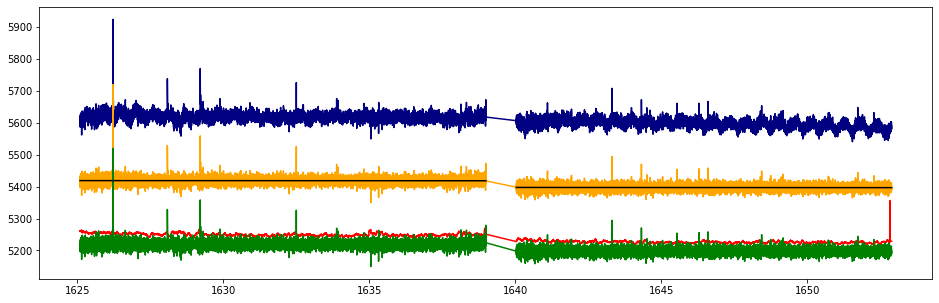

In [1980]:
plt.figure(figsize=(16,5))
f = 5
plt.plot(flc.time, flc.flux+f*80, c="navy")
plt.plot(flcp.time, flcp.detrended_flux+f*40, c="orange");
plt.plot(flcd.time, flcd.it_med+3*flcd.detrended_flux_err, c="r");
plt.plot(flcd.time, flcd.detrended_flux, c="g");
for p3, le, ri in p3s:
    plt.plot(flcd.time[le:ri], p3(flcd.time[le:ri])+f*40, c="k")
#plt.xlim(1428,1430)
#plt.ylim(1400,2250)

In [1981]:
flcd.fake_flares = df
flcd = flcd.characterize_flares(ampl_bins=bins, dur_bins=bins)

In [1982]:
flcd.flares.sort_values(by="ampl_rec").head().T

,1,2,0
ampl_rec,0.0210687,0.0267769,0.0577464
cstart,288454,289265,287114
cstop,288459,289269,287119
ed_rec,9.54237,8.75233,17.814
ed_rec_err,0.608107,0.552167,0.554704
istart,2143,2874,804
istop,2148,2878,809
total_n_valid_data_points,19003,19003,19003
tstart,1628.09,1629.21,1626.23
tstop,1628.09,1629.22,1626.23


In [1933]:
with open("/work1/eilin/TESS_UCDs/TESS_UCD_flares/flare_tables/vetted_flares.csv", "a") as f:
    flcd.flares.to_csv(f, index=False, header=False)